## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons. The hope is to have this project be as comprehensive of these topics as possible. Good luck!



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [67]:
# We start by importing the necessary libraries.

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [68]:
# this function imports a CSV file to DataFrame format.
df = pd.read_csv('ab_data.csv')
df.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


b. Use the below cell to find the number of rows in the dataset.

In [69]:
# Get the number of rows

len(df)

294478

c. The number of unique users in the dataset.

In [70]:
# Get the number of unique users

df['user_id'].nunique()

290584

d. The proportion of users converted.

In [71]:
# Get the proportion of users converted.

df.converted.mean() * 100

11.96591935560551

e. The number of times the `new_page` and `treatment` don't line up.

In [72]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [73]:
old_treatment = df.query('group == "treatment" and landing_page == "old_page"' ) 
old_treatment.shape[0]

1965

In [74]:
new_control = df.query('group == "control" and landing_page == "new_page"' ) 
new_control.shape[0]

1928

In [75]:
NOTTNAT = old_treatment.shape[0] + new_control.shape[0]
NOTTNAT

3893

f. Do any of the rows have missing values?

In [76]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [77]:
df2 = df.copy()

In [78]:
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page'))]

In [79]:
df2.shape[0]

290585

In [80]:
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [81]:
unique_id = df2.groupby(['user_id']).count()
unique_id.shape[0]

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [82]:
df2.user_id.duplicated().sum()

1

In [83]:
df2.user_id.loc[df2.user_id.duplicated()]

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [84]:
df2.loc[ 2893 : 2892+1 , ]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [85]:
df2 = df2.drop_duplicates(subset='user_id', keep='first')

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [86]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [87]:
df2_C = df2.query('group == "control"').converted.mean()
df2_C

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [88]:
df2_T = df2.query('group == "treatment"').converted.mean()
df2_T

0.11880806551510564

d. What is the probability that an individual received the new page?

In [89]:
df2.query('landing_page == "new_page"').user_id.size/df2.user_id.size

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

I don't think one page leads to more conversions, the new page  leads to less conversion rate than the old page, and the difference appears to be tiny.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

H0:P𝑜𝑙𝑑 ≥ P𝑛𝑒𝑤

H1:P𝑜𝑙𝑑 < P𝑛𝑒𝑤

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [90]:
𝑝𝑛𝑒𝑤 = df2.converted.mean()
𝑝𝑛𝑒𝑤

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [91]:
𝑝𝑜𝑙𝑑 = df2.converted.mean()
𝑝𝑜𝑙𝑑

0.11959708724499628

c. What is $n_{new}$?

In [92]:
N_𝑛𝑒𝑤 = df2.query("landing_page == 'new_page'").shape[0]
N_𝑛𝑒𝑤

145310

d. What is $n_{old}$?

In [93]:
N_𝑜𝑙𝑑 = df2.query("landing_page == 'old_page'").shape[0]
N_𝑜𝑙𝑑

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [94]:
𝑛𝑒𝑤_page_converted = np.random.binomial(1, 𝑝𝑛𝑒𝑤, N_𝑛𝑒𝑤)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [95]:
𝑜𝑙𝑑_page_converted = np.random.binomial(1, 𝑝𝑜𝑙𝑑, N_𝑜𝑙𝑑)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [96]:
𝑛𝑒𝑤_page_converted.mean() - 𝑜𝑙𝑑_page_converted.mean()

0.0007274328275869435

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [97]:
p_diffs = []
new_converted_simulation = np.random.binomial(N_𝑛𝑒𝑤, 𝑝𝑛𝑒𝑤, 10000)/N_𝑛𝑒𝑤
old_converted_simulation = np.random.binomial(N_𝑜𝑙𝑑, 𝑝𝑜𝑙𝑑 , 10000)/N_𝑜𝑙𝑑
p_diffs = new_converted_simulation - old_converted_simulation

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

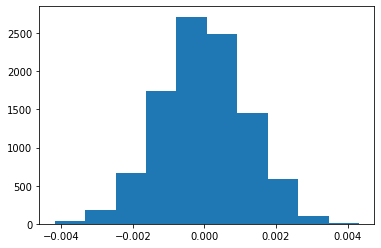

In [98]:
plt.hist(p_diffs);

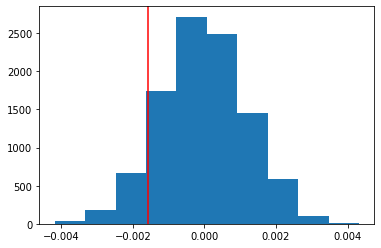

In [99]:
plt.hist(p_diffs)
real_diff = (df2.query('group == "treatment" & converted == 1').shape[0] / df2.query('group == "treatment"').shape[0]) - \
df2.query('group == "control" & converted == 1').shape[0] / df2.query('group == "control"').shape[0]
plt.axvline(x=real_diff, color='red');
plt.show()

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [100]:
(np.array(p_diffs) > real_diff).mean()

0.9048

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

This value is called the **p-value**. When you perform a hypothesis test in statistics, a **p-value** helps you determine the significance of your results. Hypothesis tests are used to test the validity of a claim that is made about a population. This claim that’s on trial, in essence, is called the null hypothesis.

The alternative hypothesis is the one you would believe if the null hypothesis is concluded to be untrue. The evidence in the trial is your data and the statistics that go along with it. All hypothesis tests ultimately use a p-value to weigh the strength of the evidence (what the data are telling you about the population). The p-value is a number between 0 and 1 and interpreted in the following way:

- A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis.

- A large p-value (> 0.05) indicates weak evidence against the null hypothesis, so you fail to reject the null hypothesis.

- p-values very close to the cutoff (0.05) are considered to be marginal (could go either way). Always report the p-value so your readers can draw their own conclusions.


However, it appears that the **p-value** is above 0.05, which means we do not have evidence to reject the null hypothesis ( Pnew=Pold ).


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [101]:
convert_old = df2.query("landing_page == 'old_page'")['converted'].sum()
convert_new = df2.query("landing_page == 'new_page'")['converted'].sum()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [102]:
import statsmodels.api as sm

z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [N_𝑛𝑒𝑤, N_𝑜𝑙𝑑], alternative = 'larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?



The z-score and p-values refer to the test statistic to be that conversion rates for the old and new pages are not statistically different from one another and to not reject the null hypothesis,
the z-score refers to the value is close to the null mean and the p-value means that there is statistical significance to confirm the findings that we calculated before and failed to reject the null.


<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

I will use **Logistic regression** because we need to know the odds of conversion, rather than a linear figure. 

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [103]:
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [104]:
import statsmodels.api as sm
df2['intercept'] = 1
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [105]:
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 17 Nov 2020   Pseudo R-squ.:               8.077e-06
Time:                        20:49:35   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The **p-value** associated with ab_page is 0.190 here, which is not similar to the previous values, but slightly lower. This model is attempting to predict whether a user will convert depending on their page. The null hypothesis is that when ab_page = 1, converted = 0; the alternative hypothesis is that when ab_page = 1, converted is more likely to be 1.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

in this investigation, it does not appear that the treatment or control page has much impact on whether a user converts. also maybe for good reason to knows there are other factors can we predicted about converted. it's important to be when choosing the factors for sure from the factors not related and not colinear.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [106]:
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [107]:
dfNew = pd.concat([countries, df2], axis=1, join='inner')
dfNew.head()

,user_id,country,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,834778,UK,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,928468,US,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,822059,UK,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,711597,UK,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,710616,UK,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


In [108]:
dfNew[['CA', 'US', 'UK']] = pd.get_dummies(dfNew['country'])

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [109]:
dfNew['US_ab_page'] = dfNew['US'] * dfNew['ab_page']
dfNew.head()

,user_id,country,user_id,timestamp,group,landing_page,converted,ab_page,intercept,CA,US,UK,US_ab_page
0,834778,UK,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,0,1,0,0
1,928468,US,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,0,0,1,0
2,822059,UK,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,0,1
3,711597,UK,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,0,1
4,710616,UK,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,0,1,0,0


In [110]:
dfNew['CA_ab_page'] = dfNew['CA'] * dfNew['ab_page']
dfNew.head()

,user_id,country,user_id,timestamp,group,landing_page,converted,ab_page,intercept,CA,US,UK,US_ab_page,CA_ab_page
0,834778,UK,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,0,1,0,0,0
1,928468,US,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,0,0,1,0,0
2,822059,UK,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,0,1,0
3,711597,UK,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,0,1,0
4,710616,UK,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,0,1,0,0,0


In [111]:
dfNew['intercept'] = 1
logit_mod = sm.Logit(dfNew['converted'], dfNew[['intercept', 'ab_page', 'UK', 'CA']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366154
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               286742
Model:                          Logit   Df Residuals:                   286738
Method:                           MLE   Df Model:                            3
Date:                Tue, 17 Nov 2020   Pseudo R-squ.:               1.523e-05
Time:                        20:49:40   Log-Likelihood:            -1.0499e+05
converged:                       True   LL-Null:                   -1.0499e+05
Covariance Type:            nonrobust   LLR p-value:                    0.3620
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9822      0.013   -154.537      0.000      -2.007      -1.957
ab_page       -0.0158      0.012     -1.376      0.169      -0.038       0.007
UK            -0.0062      0.013     -0.465      0.642      -0.032       0.020
CA            -0.0323      0.028     -1.134      0.257      -0.088       0.023
==============================================================================
"""

In [112]:
dfNew['US_ab_page'] = dfNew['US'] * df2['ab_page']
dfNew['CA_ab_page'] = dfNew['CA'] * df2['ab_page']

**Conclusions**

This regression summary shows that the country of origin and the type of page based on their p-values do not provide a statistical basis to reject the null hypothesis, based on a Type I error rate of 5%. Even with all this statistical analysis, as noted earlier, the practical significance of all this analysis does not seem required given that a .15 percent difference in the conversion rates between the control and treatment group was noted from the dataset itself, which is so minute as to not have any practical effect on deciding to switch to the new page rather than stay with the old one.

